# EDA

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
import sklearn.linear_model as linear_model
import lightgbm
import itertools
import time
import plotly.graph_objects as go
from math import ceil
import calendar
import sidetable as stb

from plotly.offline import init_notebook_mode, iplot

#conda install -c conda-forge imbalanced-learn
#conda install -c conda-forge python-graphviz
#pip install plotly
#pip install tabulate
#%matplotlib inline

In [37]:
df = pd.read_csv('H2_cleaned.csv')

Text(0, 0.5, 'Canceled vs Not Canceled')

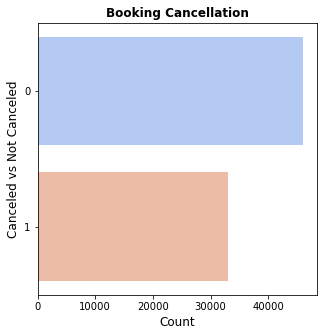

In [38]:
# Display booking cancellation 
plt.figure(figsize=(5,5))
sns.countplot(y='IsCanceled', data= df, palette='coolwarm', orient = 'v')
plt.title('Booking Cancellation', weight='bold')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Canceled vs Not Canceled', fontsize=12)

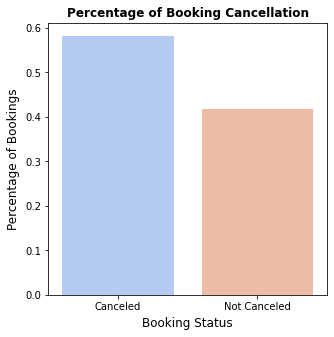

In [39]:
# Visualizing the percentage of canceled vs not canceled bookings: 
plt.figure(figsize=(5,5)) 
plt.title('Percentage of Booking Cancellation', weight='bold')
sns.barplot(x=df['IsCanceled'].unique(), y=df['IsCanceled'].value_counts(normalize=True), palette='coolwarm')
plt.xlabel("Booking Status", fontsize = 12, labelpad = 5)
plt.ylabel("Percentage of Bookings", fontsize = 12, labelpad = 5)
plt.xticks(ticks=[1, 0], labels=['Not Canceled', 'Canceled']);

0    45115
1    32955
Interpretation: 42% of bookings were canceled. This is line with the 40% cancellation rate reported by the D-Edge Study.

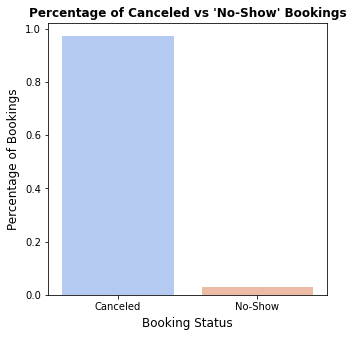

In [40]:
# Visualizing the percentage of bookings canceled prior to arrival: 
plt.figure(figsize=(5,5)) 
plt.title("Percentage of Canceled vs 'No-Show' Bookings", weight='bold')
sns.barplot(x=df[df['IsCanceled']==1]['ReservationStatus'].unique(), y=df[df['IsCanceled']==1]['ReservationStatus'].value_counts(normalize=True), palette='coolwarm')
plt.xlabel("Booking Status", fontsize = 12, labelpad = 5)
plt.ylabel("Percentage of Bookings", fontsize = 12, labelpad = 5);

In [41]:
df[df['IsCanceled']==1]['ReservationStatus'].value_counts(normalize=True)

Canceled    0.972336
No-Show     0.027664
Name: ReservationStatus, dtype: float64

Interpretation: A vast majority of bookings (97%) are canceled prior to arrival.

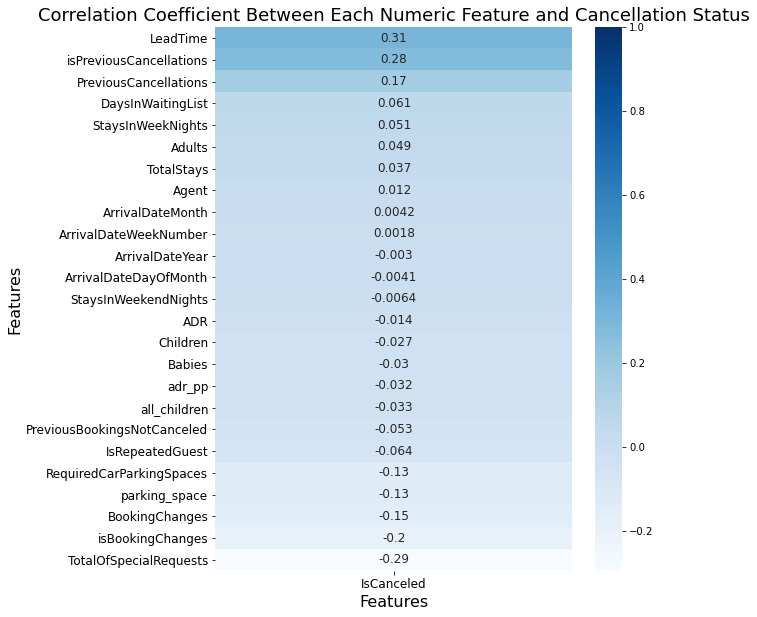

In [42]:

# Visualizing correlation coefficients between features and cancellation:
fig = plt.figure(figsize=(8,10))
ax = sns.heatmap(df.corr()[['IsCanceled']].sort_values('IsCanceled', ascending=False), annot = True, annot_kws = {"size":12}, cmap='Blues')
ax.set_title('Correlation Coefficient Between Each Numeric Feature and Cancellation Status', fontsize=18)
ax.set_xlabel('Features', fontsize = 16)
ax.set_ylabel('Features', fontsize = 16)
ax.tick_params(axis = "both", labelsize = 12);
y_min, y_max = ax.get_ylim()
ax.set_ylim(top=y_max+1);

Interpretation:

Lead time is the most highly correlated feature with whether or not a booking is canceled. It makes sense that as the number of days between when the booking is made and the supposed arrival date increases, customers have more time to cancel the reservation and there is more time for an unforeseen circumstance derailing travel plans to arise.

Total number of special requests is the second feature with the strongest correlation to the target variable. As the number of special requests made increases, the likelihood that a booking is canceled decreases. This suggests that engagement with the hotel prior to arrival and feeling like their needs are heard may make a customer less likely to cancel their reservation.

Related to special requests, the number of booking changes is the third feature with the strongest correlation to our  target varible. As the number of booking change requests increases, the likelihood that a booking is canceled decreases. 

In [43]:
# Counting adults and children as paying guests only, not babies.
df["adr_pp"] = df["ADR"] / (df["Adults"] + df["Children"])

print("""From all non-cnceled bookings, across all room types and meals, the average prices are:
Resort hotel: {:.2f} € per night and person."""
      .format(df["adr_pp"].mean()))


From all non-cnceled bookings, across all room types and meals, the average prices are:
Resort hotel: 58.49 € per night and person.


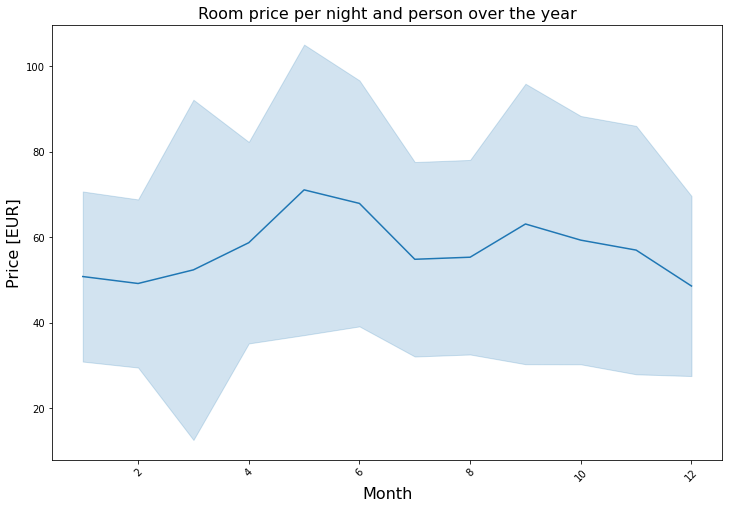

In [44]:
# grab data:
room_prices_mothly = df[["ArrivalDateMonth", "adr_pp"]].sort_values("ArrivalDateMonth")

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
room_prices_mothly["arrival_date_month"] = pd.Categorical(room_prices_mothly["ArrivalDateMonth"], categories=ordered_months, ordered=True)

# barplot with standard deviation:
plt.figure(figsize=(12, 8))
sns.lineplot(x = "ArrivalDateMonth", y="adr_pp", data=room_prices_mothly, ci="sd",  sizes=(2.5, 2.5))
plt.title("Room price per night and person over the year", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Price [EUR]", fontsize=16)
plt.show()

#drop direkt wieder
df.dropna(subset=['adr_pp'], inplace=True)

In [45]:
# Create a DateFrame with the relevant data:

num_nights_res = list(df["TotalStays"].value_counts().index)
num_bookings_res = list(df["TotalStays"].value_counts())
rel_bookings_res = df["TotalStays"].value_counts() / sum(num_bookings_res) * 100 # convert to percent

res_nights = pd.DataFrame({"hotel": "Resort hotel",
                           "num_nights": num_nights_res,
                           "rel_num_bookings": rel_bookings_res})

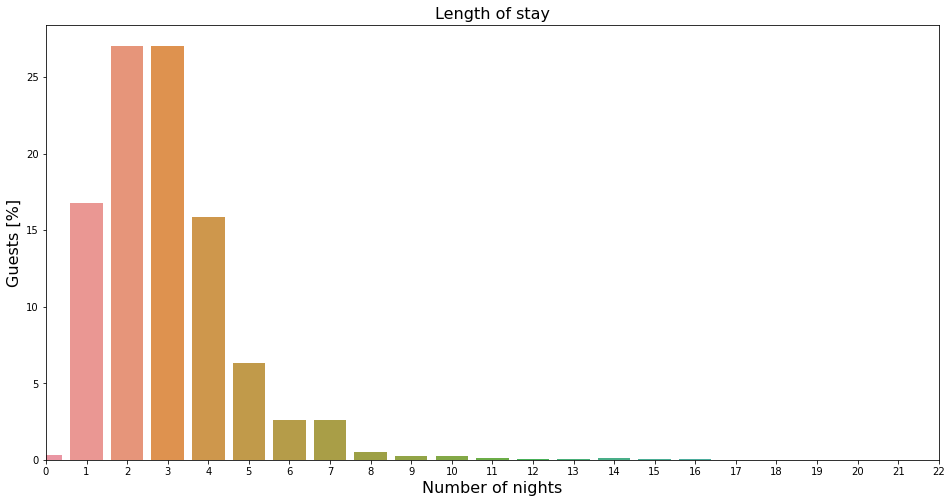

In [46]:
#show figure:
plt.figure(figsize=(16, 8))
sns.barplot(x = "num_nights", y = "rel_num_bookings",  data=res_nights)
plt.title("Length of stay", fontsize=16)
plt.xlabel("Number of nights", fontsize=16)
plt.ylabel("Guests [%]", fontsize=16)
plt.xlim(0,22)
plt.show()

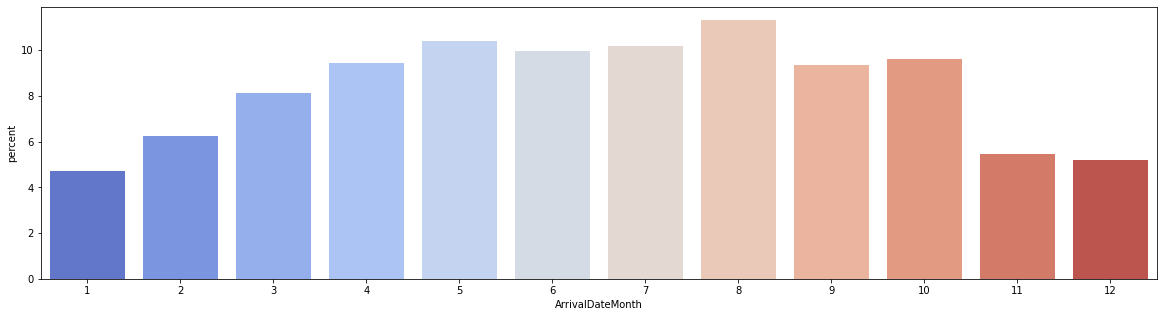

In [47]:
arrival = df.stb.freq(['ArrivalDateMonth'], cum_cols = False)
arrival
plt.figure(figsize = (20, 5))
sns.barplot(x = 'ArrivalDateMonth', y='percent', data = arrival, palette = 'coolwarm')
plt.show()

Text(0, 0.5, 'Count')

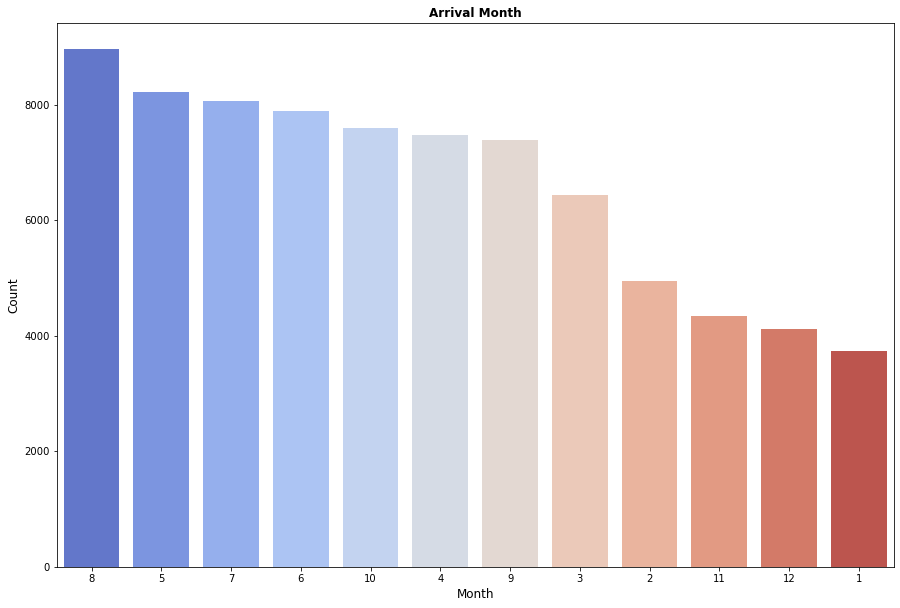

In [48]:
# Display arrival count by month 
plt.figure(figsize=(15,10))
sns.countplot(x='ArrivalDateMonth', data = df,
              order=pd.value_counts(df['ArrivalDateMonth']).index, palette='coolwarm')
plt.title('Arrival Month', weight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Count', fontsize=12)

Looking at the number of arrivals at hotels, August is the busiest month and January is the least occupied month.



In [ ]:
# Create new feature: 'weekend_or_weekday' 
pd.options.mode.chained_assignment = None
def weekendOrWeekday(feature1, feature2, data_source):
    data_source['weekend_or_weekday'] = 0
    for i in range(0, len(data_source)):
        if feature2.iloc[i] == 0 and feature1.iloc[i] > 0:
            data_source['weekend_or_weekday'].iloc[i] = 'weekend_only_stay'
        if feature2.iloc[i] > 0 and feature1.iloc[i] == 0:
            data_source['weekend_or_weekday'].iloc[i] = 'weekday_only_stay'
        if feature2.iloc[i] > 0 and feature1.iloc[i] > 0:
            data_source['weekend_or_weekday'].iloc[i] = 'weekday_and_weekend_stay'
        if feature2.iloc[i] == 0 and feature1.iloc[i] == 0:
            data_source['weekend_or_weekday'].iloc[i] = 'undefined_data'

weekendOrWeekday(df['StaysInWeekendNights'],df['StaysInWeekNights'], df)

In [ ]:
# Graph `arrival_date_month` vs `weekend_or_weekday` 
df['ArrivalDateMonth']= df['ArrivalDateMonth'].astype('int64')
groupData = df.groupby([ 'ArrivalDateMonth','weekend_or_weekday']).size().unstack(fill_value=0)
groupData.sort_values('ArrivalDateMonth', ascending = True).plot(kind='bar',stacked=True, cmap='coolwarm',figsize=(15,10))

plt.title('Arrival Month vs Weekend or Weekday Stay', weight='bold')
plt.xlabel('Arrival Month', fontsize=12)
plt.xticks(rotation=360)
plt.ylabel('Bookings', fontsize=12)

We learned that most bookings were made for weekday_only_stay or weekday_and_weekend_stay. The number of bookings made for weekend_only_stay is quite low compared to that of other categories.

In [ ]:
df['Meal'].value_counts()

In [ ]:
df.stb.freq(['Meal'], cum_cols=False)


In [ ]:
# Visualizing `meal` column data
mealLabels= ['BB','HB', 'SC', 'FB']
size = df['Meal'].value_counts()
plt.figure(figsize=(7,7))
cmap =plt.get_cmap("Pastel1")
colors = cmap(np.arange(3)*4)
myCircle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=mealLabels, colors=colors, wedgeprops = { 'linewidth' : 5, 'edgecolor' : 'white' })
p=plt.gcf()
p.gca().add_artist(myCircle)
plt.title('Meal Package Types', weight='bold')
plt.show()

In [ ]:
df.stb.freq(['DistributionChannel'], cum_cols= False)


In [ ]:
#das hier in procent:
#aspercent(df['MarketSegment'].value_counts(normalize=True),decimals=1)
df.stb.freq(['MarketSegment'], cum_cols= False)


Almost 50% of the bookings are made via Online Travel Agents while roughly 20% of bookings are made via Offline Travel Agents. Less than 10% of bookings were made directly by the customer.

In [ ]:
# Exploring `Market_segment` or booking source data
plt.figure(figsize=(10,10))
sns.countplot(df['MarketSegment'], palette='coolwarm', 
              order=pd.value_counts(df['MarketSegment']).index)
plt.title('Market Segments of Booking Source', weight='bold')
plt.xlabel('Market Segment', fontsize=12)
plt.ylabel('Count', fontsize=12)


In [ ]:
distribution_channel = df.stb.freq(['DistributionChannel'], cum_cols = False)
market_segment = df.stb.freq(['MarketSegment'], cum_cols = False)
market_segment

plt.figure(figsize = (15, 5))

plt.subplot(1,2,1)
market_segment['percent'].plot.pie(explode = [0, 0.2, 0.2, 0.2, 0.2, 1, 2], 
                                               autopct = '%1.2f%%',
                                               shadow = True
                                               )
plt.legend(market_segment['MarketSegment'])
plt.title('MarketSegment')

plt.subplot(1,2,2)
distribution_channel['percent'].plot.pie(explode = [0, 0.2, 0.2, 0.2], 
                                               autopct = '%1.2f%%',
                                               shadow = True
                                               )
plt.legend(distribution_channel['DistributionChannel'])
plt.title('DistributionChannel')

plt.suptitle('Market Segment & Distibution Channel')
plt.tight_layout()
plt.show()


In [ ]:
df.stb.freq(['IsRepeatedGuest'], cum_cols = False)


In [ ]:
# almost 95% of the booking never been cancelled before in this data set
# we will group this into booking that's never been cancelled or have been cancelled before 
df.stb.freq(['PreviousCancellations'], cum_cols = False)

In [ ]:
pd.crosstab(index = df['ReservedRoomType'], 
            columns = df['AssignedRoomType'],normalize='index').round(2)*100

In [ ]:
# Use groupby to see if number of special requests affects cancellation status
groupSpecRequest = df.groupby([ 'TotalOfSpecialRequests', 'IsCanceled']).size().unstack(fill_value=0)
groupSpecRequest.plot(kind='bar', stacked=True, cmap='coolwarm', figsize=(10,10))
plt.title('Number of Special Requests vs Booking Cancellation Status', weight='bold')
plt.xlabel('Number of Special Requests', fontsize=12)
plt.xticks(rotation=360)
plt.ylabel('Bookings', fontsize=12)

bookings with more special requests are less likely to be cancelled

In [ ]:
# Visualizing percentage of bookings canceled for each deposit type:
plt.figure(figsize=(10,5)) 
plt.title("Percentage of Bookings Canceled for Each Deposit Type", fontsize = 20, pad = 10)
sns.barplot(x=df['DepositType'], y=df['IsCanceled'], palette='coolwarm')
plt.xlabel("Deposit Type", fontsize = 12, labelpad = 5)
plt.ylabel("Percentage of Bookings Canceled", fontsize = 12, labelpad = 5);

Interpretation: Customers with a non-refundable deposit have a much higher percentage of canceled reservations. As this is a counter-intuitive finding, it is necessary to dig a little deeper into the characteristics of bookings with a non-refundable deposit.

In [ ]:
df.groupby(df['DepositType']).describe(include='all')

In [ ]:
df.to_csv('H2_cleaned.csv' ,index= False)


In [ ]:
# group data for lead_time:
lead_cancel_data = df.groupby("LeadTime")["IsCanceled"].describe()
# use only lead_times wih more than 10 bookings for graph:
lead_cancel_data_10 = lead_cancel_data.loc[lead_cancel_data["count"] >= 10]

#show figure:
plt.figure(figsize=(12, 8))
sns.regplot(x=lead_cancel_data_10.index, y=lead_cancel_data_10["mean"].values * 100)
plt.title("Effect of lead time on cancelation", fontsize=16)
plt.xlabel("Lead time", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
# plt.xlim(0,365)
plt.show()

Bookings made a few days before the arrival date are rarely canceled, whereas bookings made over one year in advance are canceled very often.

In [ ]:
deposit_cancellation = pd.crosstab(df['DepositType'],df['IsCanceled'],normalize= 'index')

fig = go.Figure(data=[
    go.Bar(name='Confirmed Booking', x=deposit_cancellation.index, y=deposit_cancellation[0]),
    go.Bar(name='Canceled Booking', x=deposit_cancellation.index, y=deposit_cancellation[1])])


fig.update_layout(barmode='group', title = 'Percentage of Cancellation for each Deposit Type',
                 yaxis=dict(
                 title='Percentage of Booking (%)',
                 titlefont_size=16,
                 tickfont_size=14,)
                ,xaxis=dict(
                 title='Deposit Type',
                 titlefont_size=16,
                 tickfont_size=14,)) 
fig.show()

# we see that almost every non refund booking are most likely to be cancelled compared to other deposit ty[e]
# while the other 2 deposit type 

In [ ]:
repeated_cancelled = pd.crosstab(df['IsRepeatedGuest'], df['IsCanceled'], normalize = 'index')


fig = go.Figure(data=[
    go.Bar(name='Confirmed Booking', x=['Non Repeated Booking', 'Repeated Booking'], y=repeated_cancelled[0]),
    go.Bar(name='Cancelled Booking', x=['Non Repeated Booking', 'Repeated Booking'], y=repeated_cancelled[1],marker_color = 'crimson')])

fig.update_layout(barmode='group', title = 'Percentage of Confirmed Booking and Cancelled Booking for Repeat & Non Repeat',
                 yaxis=dict(
                 title='Percentage of Booking (%)',
                 titlefont_size=16,
                 tickfont_size=14,)
                ,xaxis=dict(
                 title='Booking Types',
                 titlefont_size=16,
                 tickfont_size=14,))

fig.show()


# customer who has a repeated booking (existing customers) are less likely to cancel their booking compared to new customers
# non repeated booking are more than twice more likely to be cancelled compared to repeated booking 


In [ ]:
## where does all repeated guest comes from 

repeated_distribution =  pd.crosstab(df['DistributionChannel'], df['IsRepeatedGuest'], normalize = 'index')
repeated_distribution

fig = go.Figure(data=[
    go.Bar(name='Non Repeated Booking', x=repeated_distribution.index, y=repeated_distribution[0]),
    go.Bar(name='Repeated Booking', x=repeated_distribution.index, y=repeated_distribution[1])])


fig.update_layout(barmode='group', title = 'Percentage of Cancellation per Distribution Channel',
                 yaxis=dict(
                 title='Percentage of Booking (%)',
                 titlefont_size=16,
                 tickfont_size=14,)
                ,xaxis=dict(
                 title='Distribution Channel',
                 titlefont_size=16,
                 tickfont_size=14,)) 
fig.show()

# we can see  the majority of the booking from all the market segment are non repeated booking(new customers)
# however we see that corporate has the higest rate of repeated booking at (23. 5 %) that's almost a quarter means 
# almost 1 / 4 corporate booking is a repeated booking, 

In [ ]:
previously_cancelled =pd.crosstab(df['isPreviousCancellations'], df['IsCanceled'], normalize = 'index')


fig = go.Figure(data=[
    go.Bar(name='Confirmed Booking', x=previously_cancelled.index, y=previously_cancelled[0]),
    go.Bar(name='Cancelled Booking', x=previously_cancelled.index, y=previously_cancelled[1])])


fig.update_layout(barmode='group', title = 'Percentage of Previously Cancelled Booking',
                 yaxis=dict(
                 title='Percentage of Booking (%)',
                 titlefont_size=16,
                 tickfont_size=14,)
                ,xaxis=dict(
                 title='Previously Cancelled',
                 titlefont_size=16,
                 tickfont_size=14,)) 
fig.show()

# we see from the data below we see that almost 92% of booking that has been cancelled will be cancelled again


In [ ]:
parking_cancel = pd.crosstab(df['parking_space'], df['IsCanceled'], normalize = 'index')
parking_cancel

fig = go.Figure(data=[
    go.Bar(name='Confirmed Booking', x=parking_cancel.index, y=parking_cancel[0]),
    go.Bar(name='Cancelled Booking', x=parking_cancel.index, y=parking_cancel[1])])


fig.update_layout(barmode='group', title = 'Parking Space And Cancelled Booking',
                 yaxis=dict(
                 title='Percentage of Booking / Cancelled Booking (%)',
                 titlefont_size=16,
                 tickfont_size=14,)
                ,xaxis=dict(
                 title='Required Parking Space',
                 titlefont_size=16,
                 tickfont_size=14,)) 
fig.show()

# we see that booking who require a parking space never been cancelled based on the hotel booking database 
# there are around 6 % of booking that require a car parking space 